# Homework 3 - Pakes 1986
Solutions to ECO 384k Problem set 3 at the Universtiy of Texas by Eric Schulman

In [1]:
import pandas as pd
import math
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt

In [2]:
#load data from schedule/coefficients/set up states
coef = pd.read_csv('coef.csv',index_col=0)
schedule = pd.read_csv('schedule.csv')

#set up global variables
MAX_R = 2000
GRID = 20
TIME = 20
BETA = .99
STATES = np.array(range(0,MAX_R,GRID))
SIGMA, GAMMA, PHI, DELTA, SIGMA_R, MU,THETA = coef['france']

sched_1 =  np.array(schedule['sched_1'])
sched_2 =  np.array(schedule['sched_2'])

#mu, sigma - initial mean and variance
#sigma - the base variance of z  
#gamma - mean variance
#phi - scales up the variance of z based on age
#delta - scales ra plus 1
#theta - in probability of ra+1 function

In [5]:
def interpolate(r,V):
    """interpolate the value function linearly"""
    #find the index
    ind = (r/GRID).astype(int)
    interp = r/GRID - ind
    
    #pre set indexes to avoid going out of bounds
    max_ind = np.minimum(np.maximum(ind,0),MAX_R/GRID-1)
    min_ind = np.minimum(np.maximum(ind-1,0),MAX_R/GRID-1)
    
    #interpolate EV
    return (interp)*V[0][max_ind] + (1-interp)*V[0][min_ind]
    

def memoize_value(sched, l):
    """memioze the value funcion l periods into the past"""
    
    if l == TIME: #if we are in the last period
        V = [np.maximum( 0, STATES - sched[l-2])]
        return np.array(V)
        
    elif l >= 2 and l < 20:
        
        #calculate the value function this period
        V = memoize_value(sched,l+1)
        
        #caclulate value of innovation 'z'
        sigma_l = SIGMA * PHI**(l-1)
        z = sigma_l * np.exp(-GAMMA/sigma_l)
        
        #calculate the expected r next period
        exp_r = np.maximum(DELTA*STATES,z)

        #calculate expected value of V by linear interpolation
        EV_next = []
        for r in exp_r :
            EV_r = interpolate(r,V)
            EV_next.append(EV_r)
    
        #cast to np array
        EV_next = np.array([EV_next])
        
        #calculate the value funciton this period, uisn g
        V_update = np.maximum( 0, STATES + BETA*EV_next - sched[l-2])
        V = np.concatenate( (V_update , V), axis=0)
        return V
    else:
        print 'Index out of Bounds'
        return None
  
print sched_1
V =  memoize_value(sched_1,16)[0]
print V

print sched_2
V = memoize_value(sched_2,16)[0]
print V

[  0.    0.    0.   12.5  25.   37.5  50.   62.5  75.   87.5 100.  112.5
 125.  137.5 150.  162.5 175.  187.5 200. ]
[   0.            0.            0.            0.            0.
    0.            0.            0.           10.           30.
   50.           75.5873125   110.691       147.4991572   185.61905573
  227.35276673  275.3489492   326.20870821  377.44308602  430.05541137
  486.35646603  546.53369736  608.66813275  671.3502465   734.0869017
  797.88084253  865.31578836  936.69556407 1009.11250854 1081.69639456
 1154.28028059 1226.86416661 1299.44805263 1372.03193865 1444.61582468
 1517.1997107  1589.78359672 1662.36748274 1734.95136877 1807.53525479
 1880.11914081 1952.70302683 2025.28691286 2097.87079888 2170.4546849
 2243.03857092 2315.62245695 2388.20634297 2460.79022899 2533.37411501
 2605.95800104 2678.54188706 2751.12577308 2823.7096591  2896.29354513
 2968.87743115 3041.46131717 3114.04520319 3186.62908922 3259.21297524
 3331.79686126 3404.38074728 3476.96463331 3549.5

In [6]:
def value_function(r,sched,l):
    """calculate the value function l periods into the
    future for current value r"""
    r = np.float32(r)
    if l > 0 and l <=20 and r >= 0 and r <= 2000:
        V = memoize_value(sched,l+1)
        return interpolate(r,V)
    else:
        print 'value out of range'

        
def find_cutoffs(V):
    """find the sequence of cutoff values"""
    cutoffs = []
    
    for l in range(len(V)):
        for r in range(len(V[l])):
            if V[l][r] > 0:
                cutoffs.append((r)*GRID)
                break
    return cutoffs

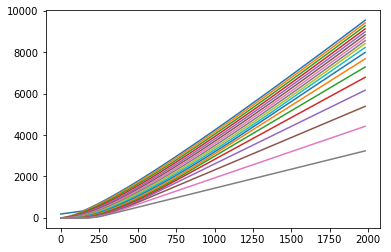

In [8]:
SCHED =  np.array(schedule['sched_1'])

#graph value function - Schedule 1
V =  memoize_value(sched_1,2)

for i in range(18):
    plt.plot(STATES, V[i])

[0, 20, 20, 20, 40, 40, 60, 80, 80, 100, 120, 120, 140, 140, 160, 180, 180, 200, 220]


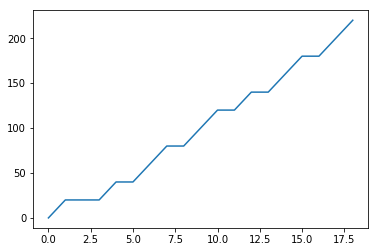

In [9]:
#graph cutoffs function - Schedule 1
cutoffs = find_cutoffs(V)
print cutoffs
plt.plot(cutoffs)

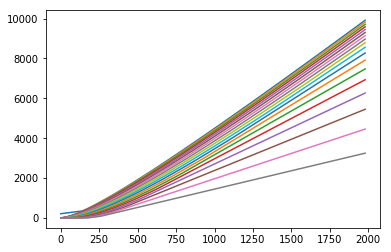

In [11]:
#graph cutoffs function - Schedule 2
V =  memoize_value(sched_2,2)
for i in range(18):
    plt.plot(STATES, V[i])

[0, 20, 20, 20, 20, 20, 20, 20, 40, 40, 60, 80, 80, 100, 120, 140, 160, 180, 220]


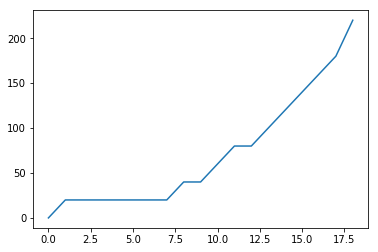

In [12]:
#graph cutoffs function - Schedule 2
cutoffs = find_cutoffs(V)
print cutoffs
plt.plot(cutoffs)